# 3.6 Predicting house prices: a regression example

This notebook serves as a lecture note on predicting house prices using a regression model. We will cover the following topics:

1.  The Boston Housing Price dataset
2.  Preparing the data
3.  Building your network
4.  Validating your approach using K-fold validation

## 1. The Boston Housing Price dataset

*   The Boston Housing Price dataset is a classic dataset used in machine learning for regression tasks.
*   It contains information about houses in the Boston area and their median values.
*   The dataset has 13 features, such as crime rate, number of rooms, and distance to employment centers, and one target variable: the median value of owner-occupied homes (in thousands of dollars).

In [ ]:
from tensorflow.keras.datasets import boston_housing

# Load the dataset
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Test targets shape: {test_targets.shape}")

# Display the first few rows of the training data
print("\nFirst few rows of training data:")
print(train_data[:5])

# Display the first few training targets
print("\nFirst few training targets:")
print(train_targets[:5])

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (404, 13)
Test data shape: (102, 13)
Training targets shape: (404,)
Test targets shape: (102,)

First few rows of training data:
[[1.23247e+00 0.00000e+00 8.14000e+00 0.00000e+00 5.38000e-01 6.14200e+00
  9.17000e+01 3.97690e+00 4.00000e+00 3.07000e+02 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 0.00000e+00 4.15000e-01 7.61000e+00
  1.57000e+01 6.27000e+00 2.00000e+00 3.48000e+02 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 0.00000e+00 6.31000e-01 4.97000e+00
  1.00000e+02 1.33250e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.75520e+02
  3.26000e+00]
 [3.96100e-02 0.00000e+00 5.19000e+00 0.00000e+00 5.15000e-01 6.03700e+00
  3.45000e+01 5.98530e+00 5.00000e+00 2.24000e+02 2.02000e+01 3.96900e+02
  8.01000e+00]
 [3.69311e+00 0.00000e+00 1.81000e+01 0.00000e+00 7.13000e-01 6.37600e+00
  8.84000e+01 2.56710e+00 2.40000e+01 6.66000e+02 2.02000e+01 3.91430e+02
  1.4

## 2. Preparing the data

*   The features in the Boston Housing dataset have different scales. For example, the crime rate is between 0 and 1, while the number of rooms is between 4 and 9.
*   Neural networks perform better when the input features are scaled to a similar range.
*   A common technique is **feature-wise normalization**, where for each feature, we subtract the mean and divide by the standard deviation.

The formula for normalization is:

$$ x_{normalized} = \frac{x - \mu}{\sigma} $$

where:
*   $x$ is the original feature value
*   $\mu$ is the mean of the feature
*   $\sigma$ is the standard deviation of the feature

In [ ]:
import numpy as np

# Normalize the training data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# Normalize the test data using the mean and standard deviation from the training data
test_data -= mean
test_data /= std

print("Training data after normalization:")
print(train_data[:5])

Training data after normalization:
[[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
   0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
  -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  -0.25683275  0.62864202 -1.82968811
   1.11048828 -1.18743907  1.67588577  1.5652875   0.78447637  0.22061726
  -1.30850006]
 [-0.40149354 -0.48361547 -0.86940196 -0.25683275 -0.3615597  -0.3245576
  -1.23667187  1.10717989 -0.51114231 -1.094663    0.78447637  0.44807713
  -0.65292624]
 [-0.0056343  -0.48361547  1.0283258  -0.25683275  1.32861221  0.15364225
   0.69480801 -0.57857203  1.67588577  1.5652875   0.78447637  0.3898823
   0.26349695]]


## 3. Building your network

*   We will build a simple feedforward neural network for this regression task.
*   The network will have two hidden layers with ReLU activation and an output layer with no activation (for regression).
*   Since we are predicting a single continuous value (house price), the output layer will have one unit.
*   The loss function for regression is typically Mean Squared Error (MSE).

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

where:
*   $n$ is the number of samples
*   $y_i$ is the actual target value
*   $\hat{y}_i$ is the predicted target value

*   We will use the Adam optimizer.
*   We will monitor the Mean Absolute Error (MAE) during training as it is more interpretable than MSE.

$$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # Single output unit for regression
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Validating your approach using K-fold validation

*   Since the dataset is small, using a simple train-validation-test split might result in the validation set being too small to be representative.
*   **K-fold cross-validation** is a technique to address this.
*   The data is split into K folds.
*   For each fold, we train the model on the remaining K-1 folds and evaluate it on the held-out fold.
*   The final evaluation metric is the average of the metrics from each fold.
*   This gives a more reliable estimate of the model's performance.

In [ ]:
import numpy as np

k = 4 # Number of folds
num_val_samples = len(train_data) // k
all_scores = []
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    # Prepare the validation data: data from fold #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other folds
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()

    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=100, batch_size=1, verbose=0)

    # Evaluate the model on the validation data
    scores = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(scores[1]) # Append MAE

    mae_history = history.history["mae"]
    all_mae_histories.append(mae_history)

# Calculate the average of the per-fold MAE scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(100)]

print(f"\nAverage MAE across all folds: {np.mean(all_scores):.2f}")

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3

Average MAE across all folds: 2.39


### Visualizing the validation results

*   We can plot the average MAE for each epoch across all folds to see how the model's performance changes during training.

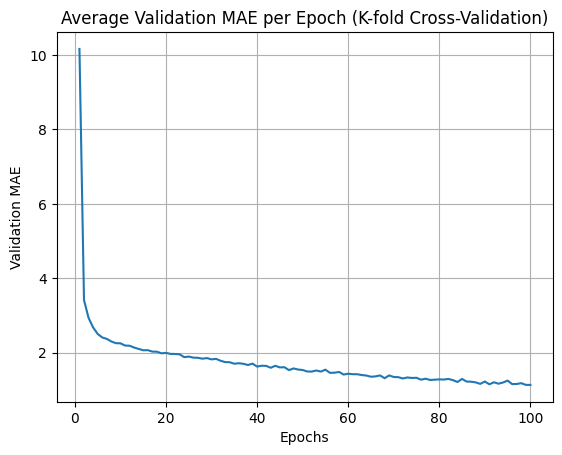

In [ ]:
import matplotlib.pyplot as plt

# Plot the average MAE history
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Average Validation MAE per Epoch (K-fold Cross-Validation)")
plt.grid(True)
plt.show()

### Final Training

*   After determining the optimal number of epochs from the validation results, we can train the final model on the entire training dataset for that number of epochs.
*   Finally, we evaluate the model on the unseen test data to get an estimate of its performance on new data.

In [ ]:
# Rebuild a fresh model
model = build_model()

# Train it on the entirety of the training data
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

# Evaluate it on the test data
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(f"\nTest MAE: {test_mae_score:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.1459 - mae: 2.4606

Test MAE: 2.64


## Summary and Conclusion

This notebook demonstrated how to build and evaluate a neural network for predicting house prices using the Boston Housing dataset.

*   We normalized the data to improve model performance.
*   We built a sequential model with dense layers.
*   We used K-fold cross-validation to validate the approach and understand the model's performance during training.
*   The final model was trained on the full training data and evaluated on the test set.

The final Mean Absolute Error (MAE) on the test set provides an indication of the model's average prediction error in thousands of dollars.

This notebook illustrates a fundamental approach to solving regression problems using neural networks and highlights the importance of data preparation and robust validation techniques like K-fold cross-validation, especially with smaller datasets.